In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer


In [2]:
import pandas as pd

# --- 1. Leer CSV en lugar de Excel ---
file_path = '../data/dataset.csv'   # ajusta la ruta si no es correcta
df = pd.read_csv(file_path)

# --- 2. Verificar que cargó bien ---
print("Dimensiones:", df.shape)
display(df.head())


Dimensiones: (21742, 58)


,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,...,D,0,NaN,NaN,NaN,NaN,0,1,0,0
1,1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,...,en trámite,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,...,no indicado,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,21739,Piso en venta en calle Pedro Jiménez,"San Andrés, Madrid",64.0,NaN,2,1.0,NaN,NaN,...,en trámite,0,NaN,NaN,NaN,NaN,0,0,1,0
4,4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,...,en trámite,1,NaN,NaN,1,0.0,1,1,1,1


In [3]:
columns_to_keep = ['neighborhood_id', 'is_renewal_needed', 'has_garden', 'energy_certificate', 'is_new_development', 'n_bathrooms', 'has_lift',
    'built_year', 'buy_price_by_area']

df = df[columns_to_keep]

print(df.columns.tolist())
df.head()

# Guardar el DataFrame actualizado en un nuevo archivo Excel
df.to_excel('first.xlsx', index=False)


['neighborhood_id', 'is_renewal_needed', 'has_garden', 'energy_certificate', 'is_new_development', 'n_bathrooms', 'has_lift', 'built_year', 'buy_price_by_area']


['0' '1' 'FALSO' 'VERDADERO']
[0 1]


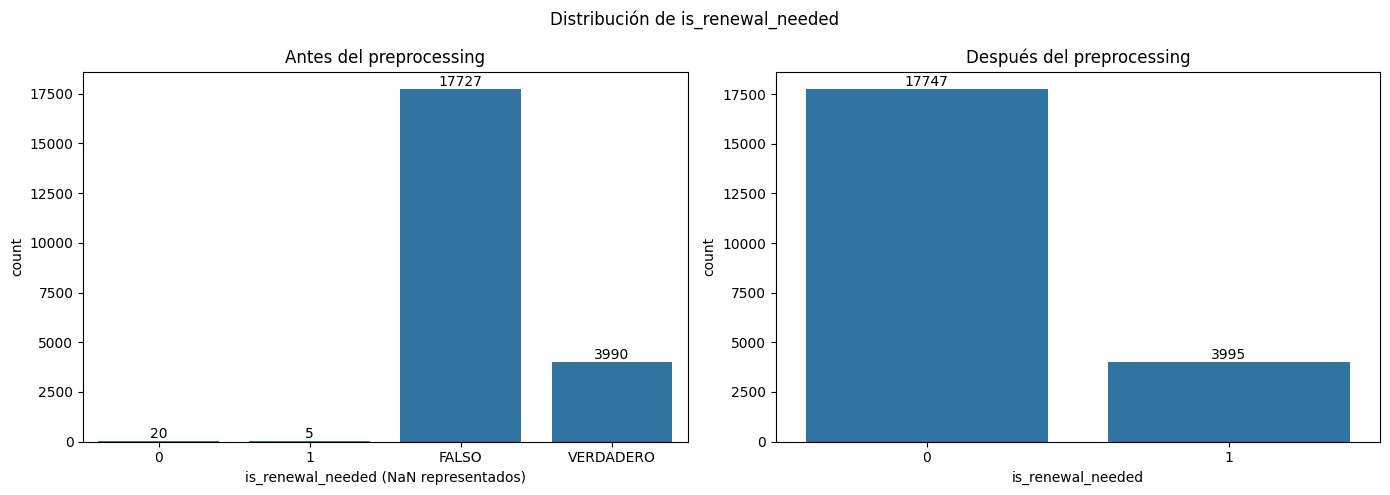

In [4]:
# 1) Ver valores únicos antes del procesamiento
print(df['is_renewal_needed'].unique())

# Guardar copia para el gráfico antes del procesamiento
df_plot_original = df['is_renewal_needed'].copy()

# 2) Reemplazar y convertir a entero
df['is_renewal_needed'] = (
    df['is_renewal_needed']
      .replace({'VERDADERO': 1, 'FALSO': 0})
      .astype(int)
)

# 3) Verificar valores únicos después
print(df['is_renewal_needed'].unique())

# 4) Plots comparativos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Distribución de is_renewal_needed")

# Antes del preprocessing
sns.countplot(x=df_plot_original.fillna('NaN'), ax=axes[0])
axes[0].set_title("Antes del preprocessing")
axes[0].set_xlabel("is_renewal_needed (NaN representados)")
axes[0].bar_label(axes[0].containers[0])

# Después del preprocessing
sns.countplot(x=df['is_renewal_needed'], ax=axes[1])
axes[1].set_title("Después del preprocessing")
axes[1].set_xlabel("is_renewal_needed")
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()
plt.show()

Valores únicos antes: [nan 'VERDADERO']
Valores únicos después: [0 1]


C:\Users\alejf\AppData\Local\Temp\ipykernel_4524\657473456.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['has_garden'] = df['has_garden'].fillna(0)


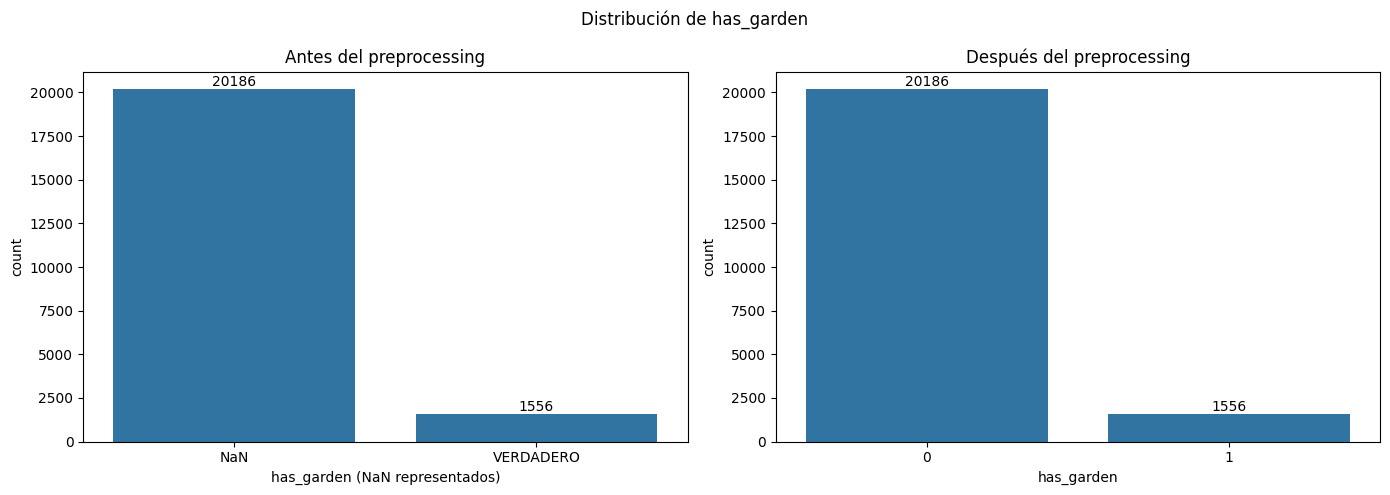

In [5]:

# 1) Ver valores únicos antes del procesamiento
print("Valores únicos antes:", df['has_garden'].unique())

# Guardar copia para el gráfico antes del procesamiento
df_plot_original = df['has_garden'].copy()

# 2) Conversión robusta
df.loc[df['has_garden'] == 'VERDADERO', 'has_garden'] = 1
df['has_garden'] = df['has_garden'].fillna(0)
df['has_garden'] = df['has_garden'].astype(int)

# 3) Verificar valores únicos después
print("Valores únicos después:", df['has_garden'].unique())

# 4) Plots comparativos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Distribución de has_garden")

# Antes del preprocessing
sns.countplot(x=df_plot_original.fillna('NaN'), ax=axes[0])
axes[0].set_title("Antes del preprocessing")
axes[0].set_xlabel("has_garden (NaN representados)")
axes[0].bar_label(axes[0].containers[0])

# Después del preprocessing
sns.countplot(x=df['has_garden'], ax=axes[1])
axes[1].set_title("Después del preprocessing")
axes[1].set_xlabel("has_garden")
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()
plt.show()


In [6]:
# Definir función mejorada
def split_neighborhood_info(text):
    try:
        match = re.match(
            r"Neighborhood (\d+): (.+?) \(([\d.,Nn][\d.,None]*) €/m2\) - District (\d+): (.+)", 
            text
        )
        if match:
            neighborhood_num = int(match.group(1))
            neighborhood_name = match.group(2)
            price_raw = match.group(3)
            # Detectar si es 'None' o un número
            if 'None' in price_raw or 'none' in price_raw:
                price_per_m2 = np.nan
            else:
                price_per_m2 = float(price_raw.replace(',', ''))
            district_id = int(match.group(4))
            district_name = match.group(5)
            return pd.Series([neighborhood_num, neighborhood_name, price_per_m2, district_id, district_name])
        else:
            return pd.Series([None, None, None, None, None])
    except Exception as e:
        print(f"Error processing row: {text}")
        print(e)
        return pd.Series([None, None, None, None, None])

In [7]:
df[['neighborhood_num', 'neighborhood_name', 'price_per_m2', 'district_id', 'district_name']] = df['neighborhood_id'].apply(split_neighborhood_info)

df[['neighborhood_num', 'neighborhood_name', 'price_per_m2', 'district_id', 'district_name']].head()




,neighborhood_num,neighborhood_name,price_per_m2,district_id,district_name
0,135,San Cristóbal,1308.89,21,Villaverde
1,132,Los Ángeles,1796.68,21,Villaverde
2,134,San Andrés,1617.18,21,Villaverde
3,134,San Andrés,1617.18,21,Villaverde
4,133,Los Rosales,1827.79,21,Villaverde


['D' 'en trámite' 'no indicado' 'F' 'E' 'inmueble exento' 'B' 'A' 'G' 'C']
Antes KNN: (21742, 6)
Después KNN: (21742, 6)


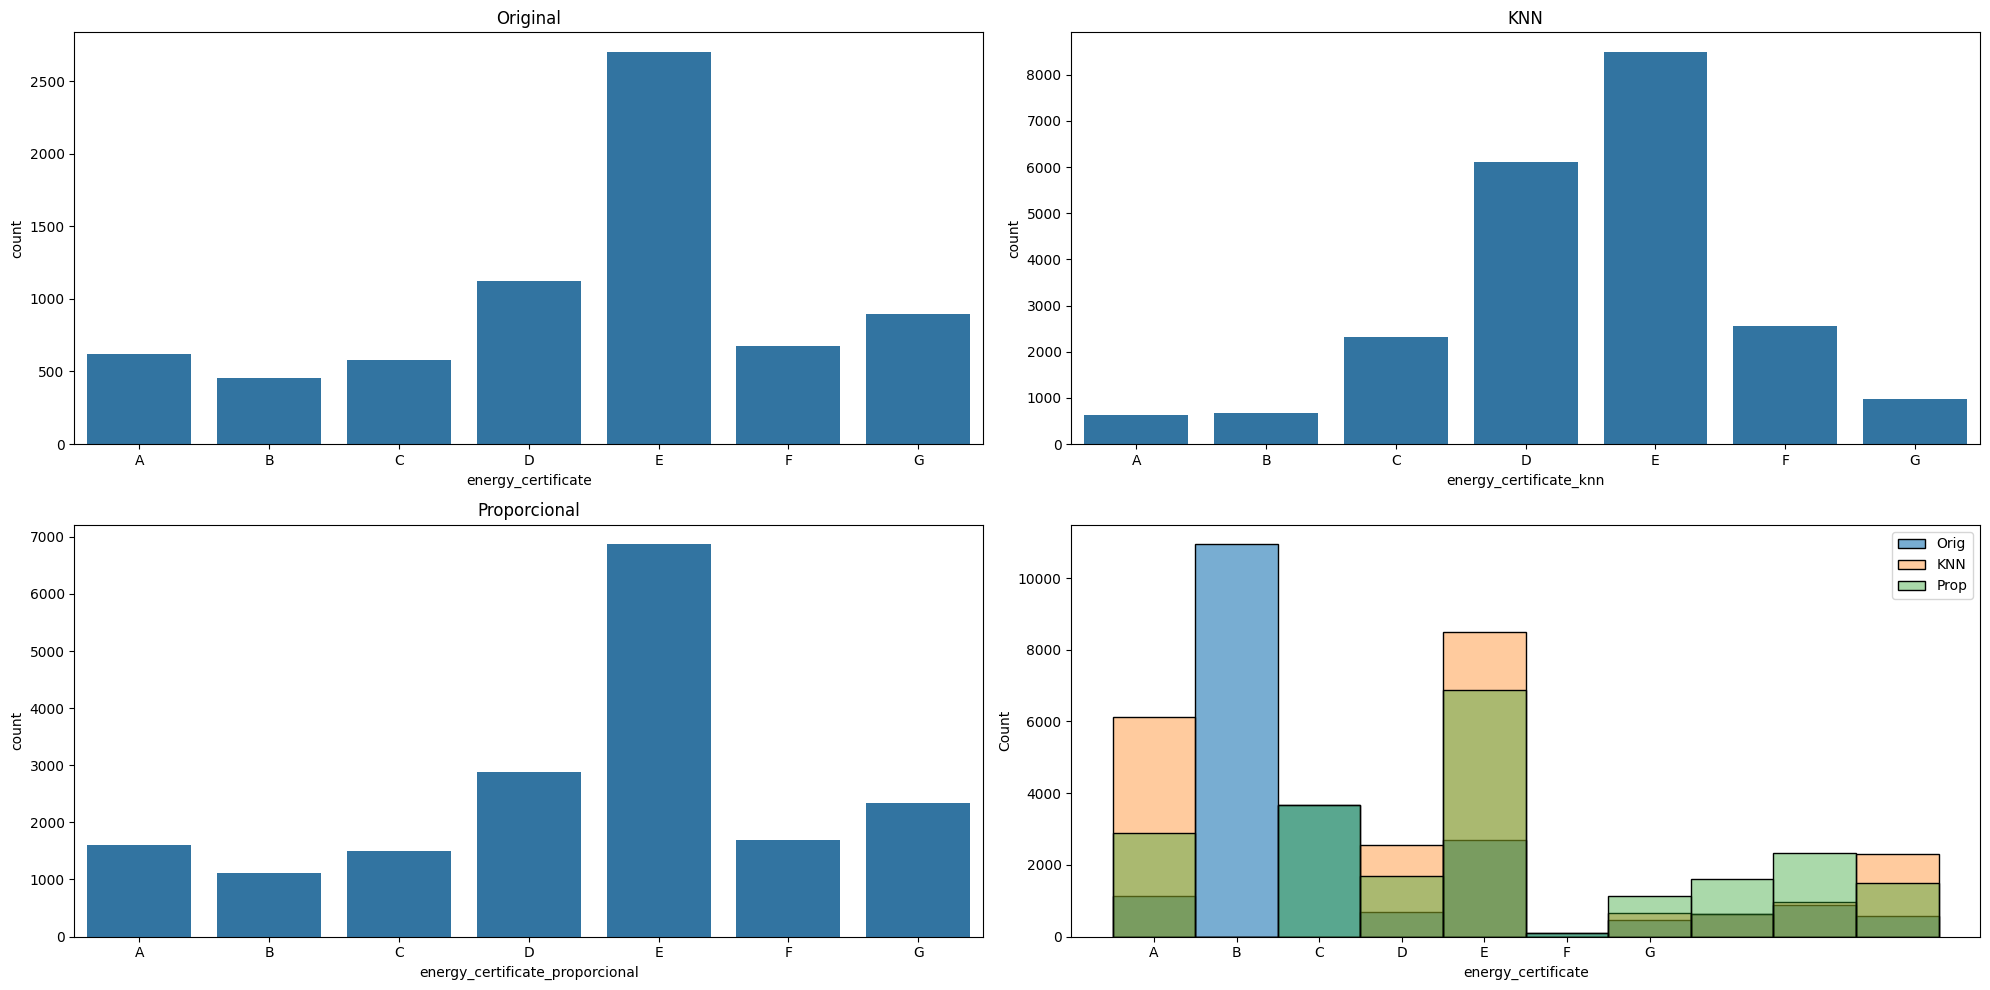

% NaN final en ‘energy_certificate’: 0.00%


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

# --- 0. Carga tu df antes de esto ---
print(df['energy_certificate'].unique())

# --- 1. Lista de certificados válidos ---
cert_vals = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# --- 2. Imputación proporcional por distrito ---
mask_valid = df['energy_certificate'].isin(cert_vals)
dist_por_distrito = (
    df[mask_valid]
    .groupby('district_name')['energy_certificate']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

def imputar_por_distrito(row):
    if row['energy_certificate'] == 'en trámite':
        distrito = row['district_name']
        if distrito in dist_por_distrito.index:
            probs = dist_por_distrito.loc[distrito]
            return np.random.choice(probs.index, p=probs.values)
    return row['energy_certificate']

df['energy_certificate_proporcional'] = df.apply(imputar_por_distrito, axis=1)

# --- 3. Preparación y KNN ---
# 3.1 Mapear booleanos a 1/0 (verifica valores exactos si son 'SI'/'NO', etc.)
boolean_map = {'VERDADERO': 1, 'FALSO': 0, True: 1, False: 0}
df['is_new_development_num'] = df['is_new_development'].map(boolean_map)
df['has_lift_num']           = df['has_lift'].map(boolean_map)

# 3.2 Mapear certificados A–G a 1–7; el resto queda NaN
cert_map = {c: i+1 for i, c in enumerate(cert_vals)}
inv_cert_map = {v: k for k, v in cert_map.items()}
df['energy_certificate_num'] = df['energy_certificate'].map(cert_map)

# 3.3 Selección de features y coerción a float
features = [
    'is_new_development_num',
    'n_bathrooms',
    'has_lift_num',
    'built_year',
    'buy_price_by_area',
    'energy_certificate_num'
]
df_knn = df[features].copy()
df_knn = df_knn.apply(pd.to_numeric, errors='coerce')  # todo a float/NaN

# 3.4 Comprobar forma antes
print("Antes KNN:", df_knn.shape)

imputer = KNNImputer(n_neighbors=5)
knn_array = imputer.fit_transform(df_knn)

# 3.5 Comprobar forma después
print("Después KNN:", knn_array.shape)

df_knn_imputed = pd.DataFrame(knn_array, columns=features)

# 3.6 Redondear certificado y volver a letra
codes = (
    df_knn_imputed['energy_certificate_num']
    .round()
    .clip(1, 7)
    .astype(int)
)
df['energy_certificate_knn'] = codes.map(inv_cert_map)

# --- 4. Visualización ---
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.countplot(x='energy_certificate', data=df, order=cert_vals)
plt.title("Original")
plt.subplot(2,2,2)
sns.countplot(x='energy_certificate_knn', data=df, order=cert_vals)
plt.title("KNN")
plt.subplot(2,2,3)
sns.countplot(x='energy_certificate_proporcional', data=df, order=cert_vals)
plt.title("Proporcional")
plt.subplot(2,2,4)
sns.histplot(df['energy_certificate'].dropna(), discrete=True, bins=np.arange(8)-0.5, label='Orig', alpha=0.6)
sns.histplot(df['energy_certificate_knn'], discrete=True, bins=np.arange(8)-0.5, label='KNN', alpha=0.4)
sns.histplot(df['energy_certificate_proporcional'], discrete=True, bins=np.arange(8)-0.5, label='Prop', alpha=0.4)
plt.xticks(range(7), cert_vals)
plt.legend()
plt.tight_layout()
plt.show()

# --- 5. Reemplazo final y % NaN ---
df.drop(columns=['energy_certificate'], inplace=True)
df.rename(columns={'energy_certificate_knn':'energy_certificate'}, inplace=True)
nan_pct = df['energy_certificate'].isna().mean()*100
print(f"% NaN final en ‘energy_certificate’: {nan_pct:.2f}%")


Antes de imputar:
- NaNs: 82 / 21742
- Porcentaje: 0.38%

Después de imputar:
- NaNs: 0 / 21742
- Porcentaje: 0.00%



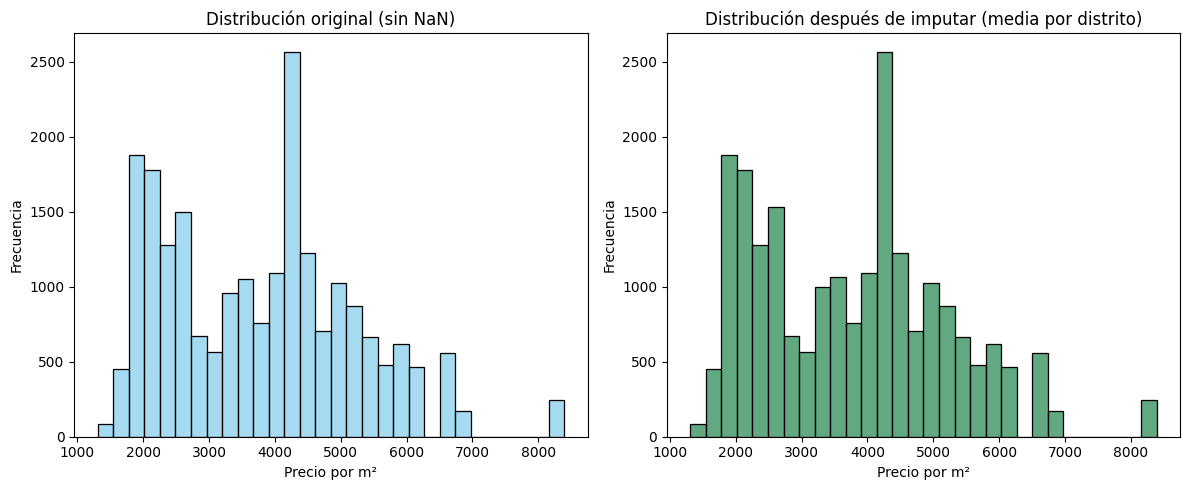

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# (1) Mostrar count y porcentaje de NaNs antes de imputar
total = len(df)
n_nan_before = df['price_per_m2'].isna().sum()
pct_nan_before = n_nan_before / total * 100
print(f"Antes de imputar:")
print(f"- NaNs: {n_nan_before} / {total}")
print(f"- Porcentaje: {pct_nan_before:.2f}%\n")

# (2) Crear copia antes de imputar para graficar
df_before = df.copy()

# (3) Calcular la media de cada distrito
district_means = df.groupby('district_id')['price_per_m2'].mean()

# (4) Imputar NaNs con la media del distrito
df['price_per_m2'] = df.apply(
    lambda row: district_means[row['district_id']] if pd.isna(row['price_per_m2']) else row['price_per_m2'],
    axis=1
)

# (5) Mostrar count y porcentaje de NaNs después de imputar
n_nan_after = df['price_per_m2'].isna().sum()
pct_nan_after = n_nan_after / total * 100
print(f"Después de imputar:")
print(f"- NaNs: {n_nan_after} / {total}")
print(f"- Porcentaje: {pct_nan_after:.2f}%\n")

# (6) Graficar la distribución antes y después
plt.figure(figsize=(12, 5))

# Antes de imputar
plt.subplot(1, 2, 1)
sns.histplot(df_before['price_per_m2'].dropna(), bins=30, color='skyblue')
plt.title("Distribución original (sin NaN)")
plt.xlabel("Precio por m²")
plt.ylabel("Frecuencia")

# Después de imputar
plt.subplot(1, 2, 2)
sns.histplot(df['price_per_m2'], bins=30, color='seagreen')
plt.title("Distribución después de imputar (media por distrito)")
plt.xlabel("Precio por m²")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


In [56]:
# Lista de columnas a eliminar
cols_to_drop = [
    'neighborhood_id',
    'neighborhood_num',
    'energy_certificate_num',
    'energy_certificate_knn',
    'energy_certificate_proporcional',
    'energy_certificate_proporcional_num',
    'is_new_development',
    'n_bathrooms',
    'buy_price_by_area',
    'district_name',
    'neighborhood_name',
    'is_new_development_num',
    'has_lift_num',


    # Añade aquí cualquier otra que no quieras usar
]

# Eliminar columnas si existen en el DataFrame
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Mostrar columnas restantes
print("Columnas restantes:")
print(df.columns.tolist())


Columnas restantes:
['is_renewal_needed', 'has_garden', 'has_lift', 'built_year', 'price_per_m2', 'district_id', 'energy_certificate']


In [57]:
# --- One Hot Encoding de 'district_id' y 'energy_certificate' ---
df = pd.get_dummies(df, columns=['district_id', 'energy_certificate'], prefix=['is_district_', 'is_ernegy_certificate_'], dtype='uint8')

# Mostrar primeras columnas resultantes
df.head()


,is_renewal_needed,has_garden,has_lift,built_year,price_per_m2,is_district__1,is_district__2,is_district__3,is_district__4,is_district__5,...,is_district__19,is_district__20,is_district__21,is_ernegy_certificate__A,is_ernegy_certificate__B,is_ernegy_certificate__C,is_ernegy_certificate__D,is_ernegy_certificate__E,is_ernegy_certificate__F,is_ernegy_certificate__G
0,0,0,0,1960.0,1308.89,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,1,0,1,NaN,1796.68,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,0,1,NaN,1617.18,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,1,1955.0,1617.18,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,1,2003.0,1827.79,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [58]:
# Guardar el DataFrame actualizado en un nuevo archivo Excel
df.to_excel('preprocessing_ale_prueba.xlsx', index=False)
